In [1]:
import pandas as pd
import numpy as np
import xlwings as xw
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup

In [2]:
def innov_round_strike(occ):
    occ_suffix = occ.split(' ')[-1]
    occ_strike_string = occ_suffix[-8:-3] + "." + occ_suffix[-3:]
    try:
        occ_strike = float(occ_strike_string)
        return int(round(occ_strike,0))
    except ValueError:
        return np.nan

def innov_expiration(occ):
    occ_suffix = occ.split(' ')[-1]
    exp_string = occ_suffix[:6]
    
    try:
        exp_dt = dt.datetime.strptime(exp_string, '%y%m%d') 
        return exp_dt
    except ValueError:
        pass 
    
def innov_underlying(occ):
    occ_prefix = occ.split(' ')[0]
    return occ_prefix[1:]

def innov_cp(occ):
    occ_suffix = occ.split(' ')[-1]
    return occ_suffix[6].lower()

def build_occ_innov(cusip):
    occ_prefix = cusip.split(" ")[0][1:]
    occ_suffix = cusip.split(" ")[-1]
    leading_zeros = 21 - len(occ_prefix + occ_suffix)
    return occ_prefix + leading_zeros * " " + occ_suffix


In [3]:
def vest_expiration(desc):
    exp_date_string = desc.split(' ')[0]
    return dt.datetime.strptime(exp_date_string, '%Y-%m-%d')

def vest_round_strike(desc):
    strike_string = desc.split(' ')[-1]
    strike_float = float(strike_string)
    return int(round(strike_float, 0))

def vest_cp(desc):
    return desc.split(' ')[-2].lower()

def vest_clean_qty(raw_qty):
    try:
        no_comma = raw_qty.replace(',','')
    except:
        return int(raw_qty)
    return int(no_comma)


def build_occ_vest(df):
    underlying = df['underlying']
    cp = df['cp'].upper()
    
    strike_str = (5 - len(str(df['strike']))) * '0' + str(df['strike']) + '0'*3
    
    exp_yy = str(df['expiration'].year - 2000)
    
    if len(str(df['expiration'].month)) == 2:
        exp_mm = str(df['expiration'].month)
    else:
        exp_mm = '0' + str(df['expiration'].month)
        
    if len(str(df['expiration'].day)) == 2:
        exp_dd = str(df['expiration'].day)
    else:
        exp_dd = '0' + str(df['expiration'].day)
    
    exp_str = exp_yy + exp_mm + exp_dd
    
    occ_suffix = exp_str + cp + strike_str
    
    occ_chars = underlying + occ_suffix
    leading_spaces = 21 - len(occ_chars)
    
    df['occ_symbol'] = underlying + leading_spaces * " " + occ_suffix 
    
    return df




In [4]:
def get_innov_data():
    book = xw.Book('data_innovator.xlsx')
    book.api.RefreshAll()
    sheet = book.sheets('holdings')
    df = sheet.range('A1').options(convert=pd.DataFrame, expand='table', index=False).value
    book.save()
    book.close()
    df.columns = [c.lower() for c in df.columns]

    df['underlying'] = df['cusip'].apply(innov_underlying)
    df['expiration'] = df['cusip'].apply(innov_expiration)
    df['strike'] = df['cusip'].apply(innov_round_strike)

    df['cp'] = df['cusip'].apply(innov_cp)
    
    df['expiration'] = pd.to_datetime(df['expiration'])
    
    return df

def get_vest_data():
    vest_tickers = ['DJAN','DFEB','DMAR','DARP','DMAY','DJUN','DJUL','DAUG','DSEP','DOCT','DNOV','DDEC',
                'FJAN','FFEB','FMAR','FAPR','FMAY','FJUN','FJUL','FAUG','FSEP','FOCT','FNOV','FDEC']

    vest_holdings_url_root = r'https://www.ftportfolios.com/Retail/Etf/EtfHoldings.aspx?Ticker='
    vest_holdings_urls = [vest_holdings_url_root + ticker for ticker in vest_tickers]

    positions = {}
    
    for i,url in enumerate(vest_holdings_urls):

        request = requests.get(url) 
        soup = BeautifulSoup(request.content, 'html.parser')
        table = soup.find('table', class_='fundSilverGrid')
        try:
            rows = table.find_all('tr')[1:]
        except:
            continue
        for row in rows:
            datapoints = row.find_all('td')
            if datapoints[0].text != 'US Dollar':
                positions[datapoints[0].text] = datapoints[3].text

    
    df = pd.DataFrame([positions.keys(),positions.values()]).T
    df.columns = ['desc','qty']
    
    df = pd.DataFrame([positions.keys(),positions.values()]).T
    df.columns = ['desc','qty']
    df['underlying'] = 'SPY'
    df['expiration'] = df['desc'].apply(vest_expiration)
    df['strike'] = df['desc'].apply(vest_round_strike)
    df['cp'] = df['desc'].apply(vest_cp)
    df['qty'] = df['qty'].apply(vest_clean_qty)
    
    return df

In [5]:
vest_data = get_vest_data()
innov_data = get_innov_data()
innov_data.dropna(axis=0, subset=['expiration'], inplace=True)

In [6]:
spy_price = 510

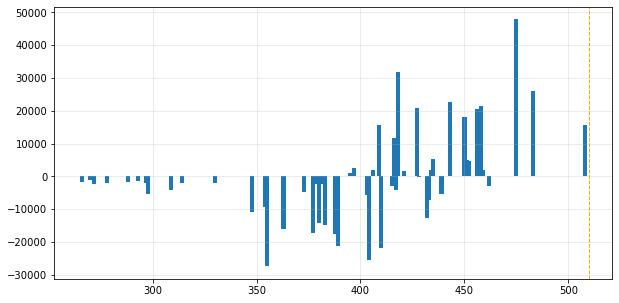

In [7]:
innov_puts = innov_data.loc[(innov_data['underlying'] == 'SPY')&(innov_data['cp'] == 'p')]
#innov_puts.groupby('strike').sum()['shares'].plot(kind='bar',figsize=[15,5], ylim=(-20000,20000))
innov_puts_bystrike = innov_puts.groupby('strike').sum()['shares']
innov_puts_bystrike = innov_puts_bystrike.loc[innov_puts_bystrike.index>10]
plt.figure(figsize=[10,5])
plt.bar(innov_puts_bystrike.index, innov_puts_bystrike, width=2)
plt.axvline(spy_price, color='orange', ls='--', lw=1)
plt.grid(lw=0.5, alpha=0.5)


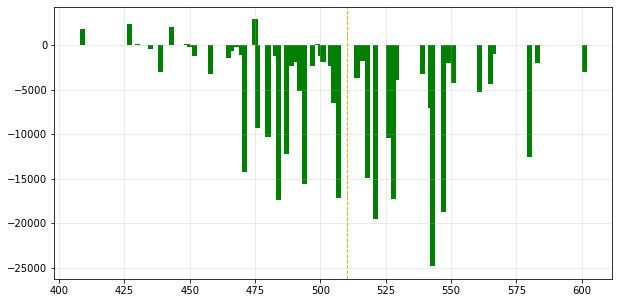

In [8]:
innov_calls = innov_data.loc[(innov_data['underlying'] == 'SPY')&(innov_data['cp'] == 'c')&(innov_data['strike']>100)]
#innov_calls.groupby('strike').sum()['shares'].plot(kind='bar',figsize=[15,5], color='green')
innov_calls_bystrike = innov_calls.groupby('strike').sum()['shares']
plt.figure(figsize=[10,5])
plt.bar(innov_calls_bystrike.index, innov_calls_bystrike, width=2, color='green')
plt.axvline(spy_price, color='orange', ls='--', lw=1)
plt.grid(lw=0.5, alpha=0.5)

Text(0.5, 1.0, 'Innovator - ALL SPY')

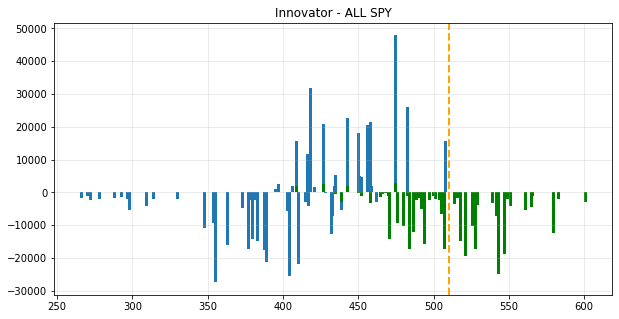

In [9]:
plt.figure(figsize=[10,5])
plt.bar(innov_puts_bystrike.index, innov_puts_bystrike, width=2)
plt.bar(innov_calls_bystrike.index, innov_calls_bystrike, width=2, color='green')
plt.axvline(spy_price, color='orange', ls='--', lw=2)
plt.grid(lw=0.5, alpha=0.5)
plt.title('Innovator - ALL SPY')

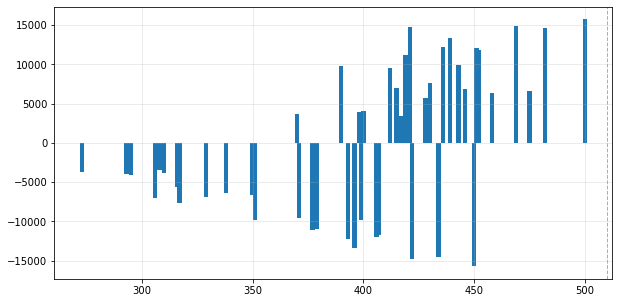

In [10]:
vest_puts = vest_data.loc[(vest_data['cp'] == 'p') & (vest_data['underlying'] == 'SPY')]
#vest_puts.groupby('strike').sum()['qty'].plot(kind='bar', figsize=[15,5])
vest_puts_bystrike = vest_puts.groupby('strike').sum()['qty']
plt.figure(figsize=[10,5])
plt.bar(vest_puts_bystrike.index, vest_puts_bystrike, width=2)
plt.axvline(spy_price, color='orange', ls='--', lw=1)
plt.grid(lw=0.5, alpha=0.5)

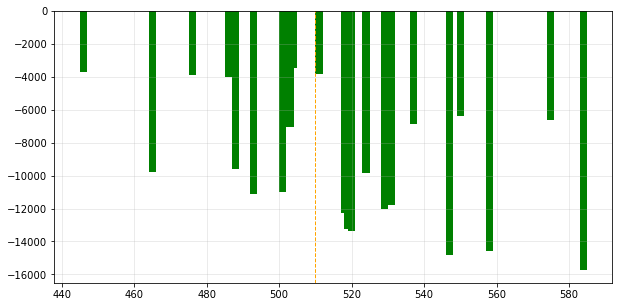

In [11]:
vest_calls = vest_data.loc[(vest_data['cp'] == 'c') & (vest_data['underlying'] == 'SPY') & (vest_data['strike'] > 100)]
#vest_calls.groupby('strike').sum()['qty'].plot(kind='bar', figsize=[15,5],color='green')
vest_calls_bystrike = vest_calls.groupby('strike').sum()['qty']
plt.figure(figsize=[10,5])
plt.bar(vest_calls_bystrike.index, vest_calls_bystrike, width=2, color='green')
plt.axvline(spy_price, color='orange', ls='--', lw=1)
plt.grid(lw=0.5, alpha=0.5)

Text(0.5, 1.0, 'VEST - All SPY')

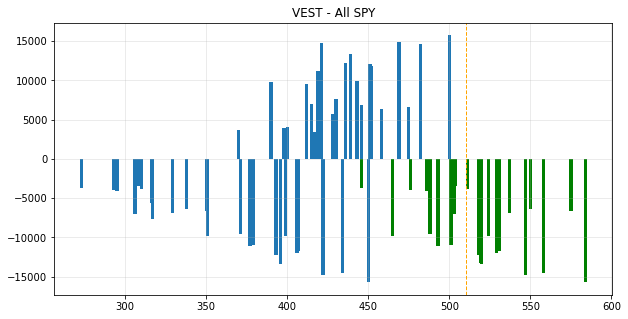

In [12]:
vest_calls = vest_data.loc[(vest_data['cp'] == 'c') & (vest_data['underlying'] == 'SPY') & (vest_data['strike'] > 100)]
#vest_calls.groupby('strike').sum()['qty'].plot(kind='bar', figsize=[15,5],color='green')
vest_calls_bystrike = vest_calls.groupby('strike').sum()['qty']
plt.figure(figsize=[10,5])
plt.bar(vest_puts_bystrike.index, vest_puts_bystrike, width=2)
plt.bar(vest_calls_bystrike.index, vest_calls_bystrike, width=2, color='green')
plt.axvline(spy_price, color='orange', ls='--', lw=1)
plt.grid(lw=0.5, alpha=0.5)
plt.title('VEST - All SPY')

IndexError: index 14 is out of bounds for axis 0 with size 14

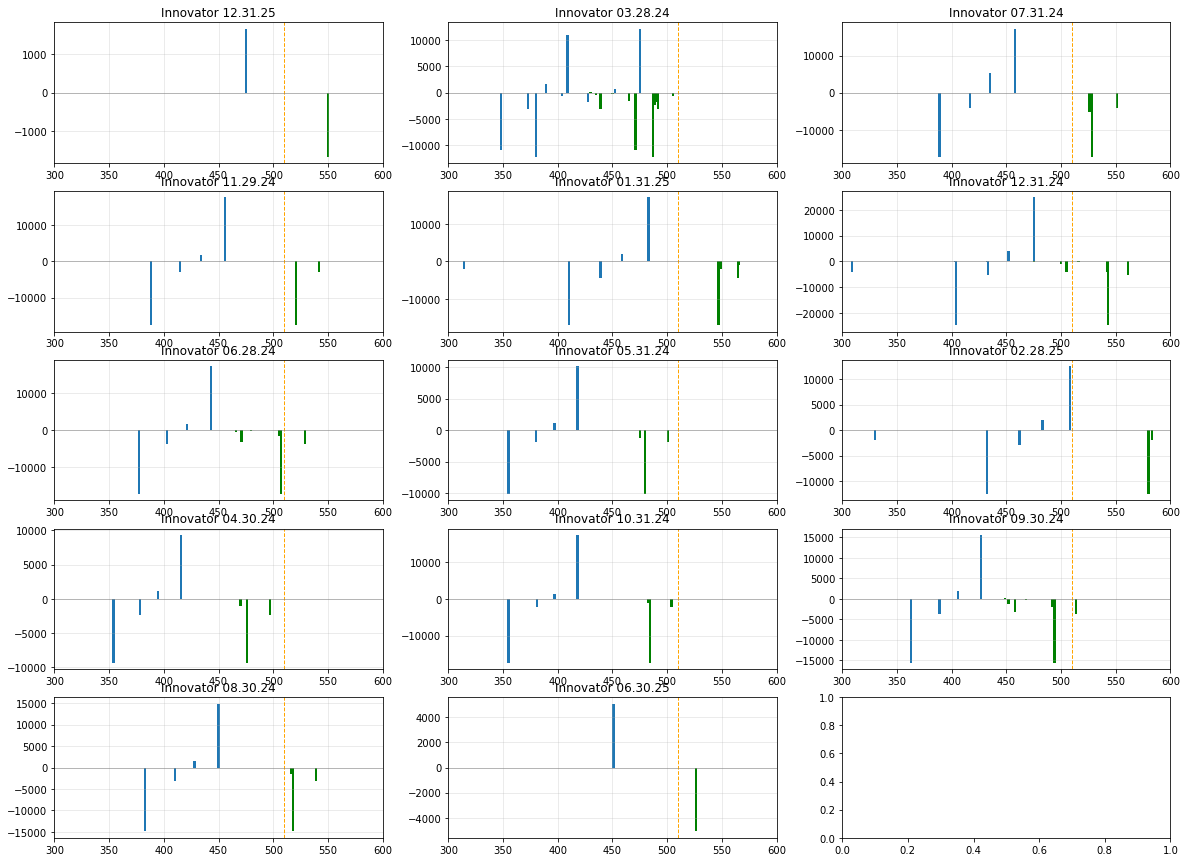

In [15]:
innov_sp = innov_data[innov_data['underlying'] == 'SPY']
innov_expirations = innov_sp['expiration'].unique()
num_plots = innov_expirations.shape[0]
cols = 3
remainder = 1 if num_plots % cols > 0 else 0 
rows = int(num_plots / cols) + remainder

fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(20,15), sharex=False)
exp_index = 0
for row in range(rows):
    for col in range(cols):
        expiration = innov_expirations[exp_index]
        exp_filter = innov_sp[innov_sp['expiration'] == expiration]
        calls = exp_filter.loc[exp_filter['cp'] == 'c']
        puts = exp_filter.loc[exp_filter['cp'] == 'p']
        axs[row, col].bar(calls['strike'], calls['shares'], color='green', width=2)
        axs[row, col].bar(puts['strike'], puts['shares'], width=2)
        axs[row, col].axvline(spy_price, ls='--', lw=1, color='orange')
        axs[row, col].axhline(0, lw=0.5, color='gray')
        axs[row, col].set_title("Innovator " + pd.to_datetime(expiration).strftime('%m.%d.%y'))
        axs[row, col].set_xlim((300,600))
        axs[row, col].grid(lw=0.5, alpha=0.5)
        exp_index += 1


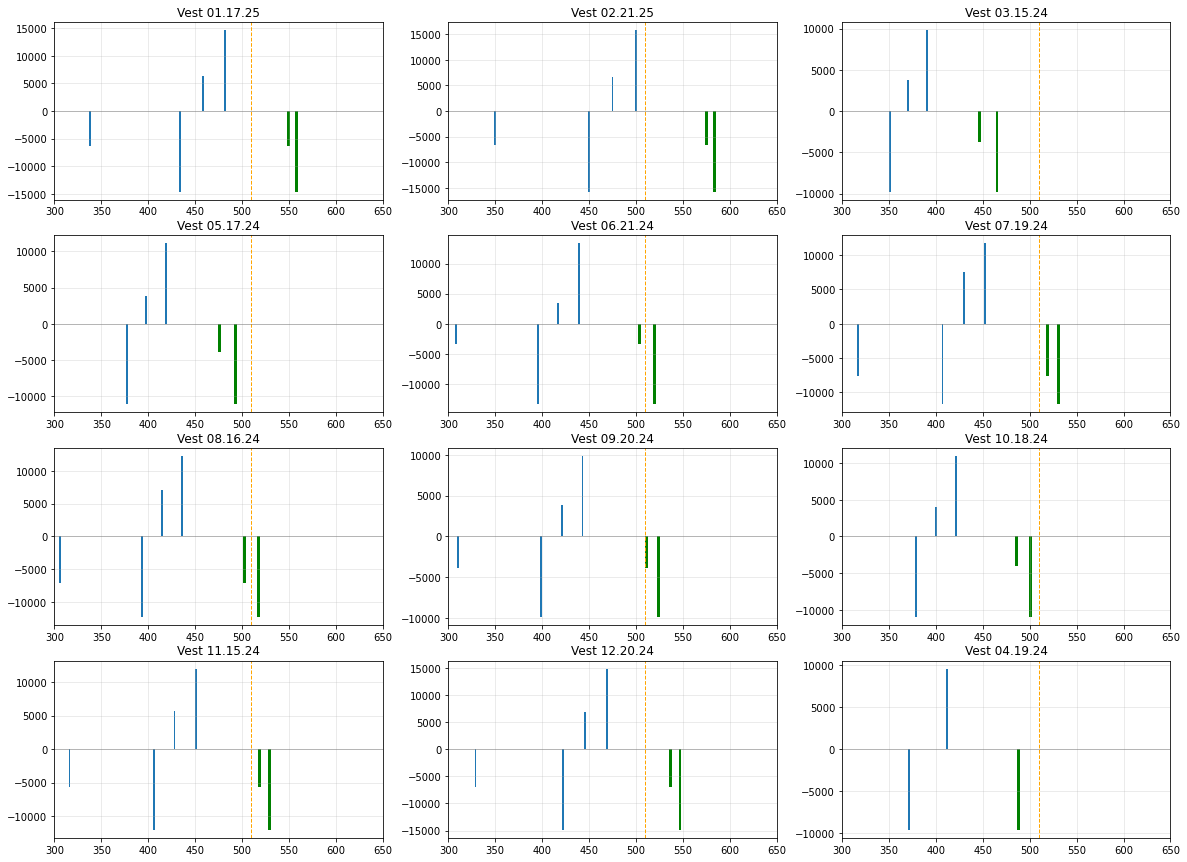

In [16]:
vest_expirations = vest_data['expiration'].unique()
num_plots = vest_expirations.shape[0]
cols = 3
remainder = 1 if num_plots % cols > 0 else 0 
rows = int(num_plots / cols) + remainder

fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(20,15), sharex=False)
exp_index = 0
for row in range(rows):
    for col in range(cols):
        expiration = vest_expirations[exp_index]
        exp_filter = vest_data[vest_data['expiration'] == expiration]
        calls = exp_filter.loc[exp_filter['cp'] == 'c']
        puts = exp_filter.loc[exp_filter['cp'] == 'p']
        axs[row, col].bar(calls['strike'], calls['qty'], color='green', width=3)
        axs[row, col].bar(puts['strike'], puts['qty'], width=2)
        axs[row, col].axvline(spy_price, ls='--', lw=1, color='orange')
        axs[row, col].axhline(0, lw=0.5, color='gray')
        axs[row, col].set_title("Vest " + pd.to_datetime(expiration).strftime('%m.%d.%y'))
        axs[row, col].set_xlim((300,650))
        axs[row, col].grid(lw=0.5, alpha=0.5)
        exp_index += 1

In [40]:
innov_data[innov_data['account'] == 'BALT']

,date,account,stockticker,cusip,securityname,shares,price,marketvalue,weightings,netassets,sharesoutstanding,creationunits,moneymarketflag,underlying,expiration,strike,cp
32,2023-06-01,BALT,2SPY 230630C00001020,2SPY 230630C00001020,SPY 06/30/2023 1.02 C,9408.0,415.03,390460224.0,1.0032,389197165.0,14150000.0,566.0,,SPY,2023-06-30,1.0,c
33,2023-06-01,BALT,2SPY 230630C00420120,2SPY 230630C00420120,SPY 06/30/2023 420.12 C,-9408.0,5.44,-5117952.0,-0.0132,389197165.0,14150000.0,566.0,,SPY,2023-06-30,420.0,c
34,2023-06-01,BALT,2SPY 230630P00327510,2SPY 230630P00327510,SPY 06/30/2023 327.51 P,-9408.0,0.22,-206976.0,-0.0005,389197165.0,14150000.0,566.0,,SPY,2023-06-30,328.0,p
35,2023-06-01,BALT,2SPY 230630P00409390,2SPY 230630P00409390,SPY 06/30/2023 409.39 P,9408.0,4.00,3763200.0,0.0097,389197165.0,14150000.0,566.0,,SPY,2023-06-30,409.0,p


,date,account,stockticker,cusip,securityname,shares,price,marketvalue,weightings,netassets,sharesoutstanding,creationunits,moneymarketflag,underlying,expiration,strike,cp
32,2023-06-01,BALT,2SPY 230630C00001020,2SPY 230630C00001020,SPY 06/30/2023 1.02 C,9408.0,415.03,390460224.0,1.0032,389197165.0,14150000.0,566.0,,SPY,2023-06-30,1.0,c
33,2023-06-01,BALT,2SPY 230630C00420120,2SPY 230630C00420120,SPY 06/30/2023 420.12 C,-9408.0,5.44,-5117952.0,-0.0132,389197165.0,14150000.0,566.0,,SPY,2023-06-30,420.0,c
34,2023-06-01,BALT,2SPY 230630P00327510,2SPY 230630P00327510,SPY 06/30/2023 327.51 P,-9408.0,0.22,-206976.0,-0.0005,389197165.0,14150000.0,566.0,,SPY,2023-06-30,328.0,p
35,2023-06-01,BALT,2SPY 230630P00409390,2SPY 230630P00409390,SPY 06/30/2023 409.39 P,9408.0,4.00,3763200.0,0.0097,389197165.0,14150000.0,566.0,,SPY,2023-06-30,409.0,p


In [41]:
vest_data['expiration'].value_counts(dropna=False)

2024-01-19    8
2024-02-16    8
2024-03-15    8
2024-05-17    8
2023-06-16    8
2023-07-21    8
2023-08-18    8
2023-09-15    8
2023-10-20    8
2023-11-17    8
2023-12-15    8
2024-04-19    4
Name: expiration, dtype: int64

2024-01-19    8
2024-02-16    8
2024-03-15    8
2024-05-17    8
2023-06-16    8
2023-07-21    8
2023-08-18    8
2023-09-15    8
2023-10-20    8
2023-11-17    8
2023-12-15    8
2024-04-19    4
Name: expiration, dtype: int64

In [42]:
innov_data[innov_data['account']=='PJUN']

,date,account,stockticker,cusip,securityname,shares,price,marketvalue,weightings,netassets,sharesoutstanding,creationunits,moneymarketflag,underlying,expiration,strike,cp
994,2023-06-01,PJUN,2SPY 240531C00004180,2SPY 240531C00004180,SPY 05/31/2024 4.18 C,11266.0,408.33,460024578.0,0.9849,467057175.0,15250000.0,610.0,,SPY,2024-05-31,4.0,c
995,2023-06-01,PJUN,2SPY 240531C00479820,2SPY 240531C00479820,SPY 05/31/2024 479.82 C,-11266.0,7.45,-8393170.0,-0.0180,467057175.0,15250000.0,610.0,,SPY,2024-05-31,480.0,c
996,2023-06-01,PJUN,2SPY 240531P00355170,2SPY 240531P00355170,SPY 05/31/2024 355.17 P,-11266.0,10.35,-11660310.0,-0.0250,467057175.0,15250000.0,610.0,,SPY,2024-05-31,355.0,p
997,2023-06-01,PJUN,2SPY 240531P00417850,2SPY 240531P00417850,SPY 05/31/2024 417.85 P,11266.0,23.14,26069524.0,0.0558,467057175.0,15250000.0,610.0,,SPY,2024-05-31,418.0,p


,date,account,stockticker,cusip,securityname,shares,price,marketvalue,weightings,netassets,sharesoutstanding,creationunits,moneymarketflag,underlying,expiration,strike,cp
994,2023-06-01,PJUN,2SPY 240531C00004180,2SPY 240531C00004180,SPY 05/31/2024 4.18 C,11266.0,408.33,460024578.0,0.9849,467057175.0,15250000.0,610.0,,SPY,2024-05-31,4.0,c
995,2023-06-01,PJUN,2SPY 240531C00479820,2SPY 240531C00479820,SPY 05/31/2024 479.82 C,-11266.0,7.45,-8393170.0,-0.0180,467057175.0,15250000.0,610.0,,SPY,2024-05-31,480.0,c
996,2023-06-01,PJUN,2SPY 240531P00355170,2SPY 240531P00355170,SPY 05/31/2024 355.17 P,-11266.0,10.35,-11660310.0,-0.0250,467057175.0,15250000.0,610.0,,SPY,2024-05-31,355.0,p
997,2023-06-01,PJUN,2SPY 240531P00417850,2SPY 240531P00417850,SPY 05/31/2024 417.85 P,11266.0,23.14,26069524.0,0.0558,467057175.0,15250000.0,610.0,,SPY,2024-05-31,418.0,p


In [43]:
vest_data[vest_data['expiration'] == dt.datetime(2022,12,16)]

,desc,qty,underlying,expiration,strike,cp


,desc,qty,underlying,expiration,strike,cp


In [44]:
innov_data.loc[innov_data['account'] == 'POCT']


,date,account,stockticker,cusip,securityname,shares,price,marketvalue,weightings,netassets,sharesoutstanding,creationunits,moneymarketflag,underlying,expiration,strike,cp
1014,2023-06-01,POCT,2SPY 230929C00003570,2SPY 230929C00003570,SPY 09/29/2023 3.57 C,11922.0,410.98,489970356.0,1.0168,481866700.0,14875000.0,595.0,,SPY,2023-09-29,4.0,c
1015,2023-06-01,POCT,2SPY 230929C00431220,2SPY 230929C00431220,SPY 09/29/2023 431.22 C,-11922.0,9.75,-11623950.0,-0.0241,481866700.0,14875000.0,595.0,,SPY,2023-09-29,431.0,c
1016,2023-06-01,POCT,2SPY 230929P00303600,2SPY 230929P00303600,SPY 09/29/2023 303.6 P,-11922.0,1.31,-1561782.0,-0.0032,481866700.0,14875000.0,595.0,,SPY,2023-09-29,304.0,p
1017,2023-06-01,POCT,2SPY 230929P00357180,2SPY 230929P00357180,SPY 09/29/2023 357.18 P,11922.0,3.49,4160778.0,0.0086,481866700.0,14875000.0,595.0,,SPY,2023-09-29,357.0,p


,date,account,stockticker,cusip,securityname,shares,price,marketvalue,weightings,netassets,sharesoutstanding,creationunits,moneymarketflag,underlying,expiration,strike,cp
1014,2023-06-01,POCT,2SPY 230929C00003570,2SPY 230929C00003570,SPY 09/29/2023 3.57 C,11922.0,410.98,489970356.0,1.0168,481866700.0,14875000.0,595.0,,SPY,2023-09-29,4.0,c
1015,2023-06-01,POCT,2SPY 230929C00431220,2SPY 230929C00431220,SPY 09/29/2023 431.22 C,-11922.0,9.75,-11623950.0,-0.0241,481866700.0,14875000.0,595.0,,SPY,2023-09-29,431.0,c
1016,2023-06-01,POCT,2SPY 230929P00303600,2SPY 230929P00303600,SPY 09/29/2023 303.6 P,-11922.0,1.31,-1561782.0,-0.0032,481866700.0,14875000.0,595.0,,SPY,2023-09-29,304.0,p
1017,2023-06-01,POCT,2SPY 230929P00357180,2SPY 230929P00357180,SPY 09/29/2023 357.18 P,11922.0,3.49,4160778.0,0.0086,481866700.0,14875000.0,595.0,,SPY,2023-09-29,357.0,p


In [45]:
innov_data['account'].unique()

array(['APRD', 'APRH', 'APRJ', 'APRQ', 'BALT', 'BAPR', 'BAUG', 'BDEC',
       'BFEB', 'BJAN', 'BJUL', 'BJUN', 'BMAR', 'BMAY', 'BNOV', 'BOCT',
       'BOUT', 'BSEP', 'BSTP', 'DBJA', 'DBOC', 'DSJA', 'DSOC', 'EAPR',
       'EJAN', 'EJUL', 'EOCT', 'EPRF', 'FFTY', 'IAPR', 'IGTR', 'IJAN',
       'IJUL', 'IOCT', 'KAPR', 'KJAN', 'KJUL', 'KOCT', 'LOUP', 'NAPR',
       'NJAN', 'NJUL', 'NOCT', 'PAPR', 'PAUG', 'PDEC', 'PFEB', 'PJAN',
       'PJUL', 'PJUN', 'PMAR', 'PMAY', 'PNOV', 'POCT', 'PSEP', 'PSTP',
       'QTAP', 'QTJA', 'QTJL', 'QTOC', 'SFLR', 'TBJL', 'TFJL', 'TSJA',
       'TSLH', 'TSOC', 'UAPR', 'UAUG', 'UDEC', 'UFEB', 'UJAN', 'UJUL',
       'UJUN', 'UMAR', 'UMAY', 'UNOV', 'UOCT', 'USEP', 'XBAP', 'XBJA',
       'XBJL', 'XBOC', 'XDAP', 'XDJA', 'XDJL', 'XDOC', 'XDQQ', 'XDSQ',
       'XTAP', 'XTJA', 'XTJL', 'XTOC', 'XUSP'], dtype=object)

array(['APRD', 'APRH', 'APRJ', 'APRQ', 'BALT', 'BAPR', 'BAUG', 'BDEC',
       'BFEB', 'BJAN', 'BJUL', 'BJUN', 'BMAR', 'BMAY', 'BNOV', 'BOCT',
       'BOUT', 'BSEP', 'BSTP', 'DBJA', 'DBOC', 'DSJA', 'DSOC', 'EAPR',
       'EJAN', 'EJUL', 'EOCT', 'EPRF', 'FFTY', 'IAPR', 'IGTR', 'IJAN',
       'IJUL', 'IOCT', 'KAPR', 'KJAN', 'KJUL', 'KOCT', 'LOUP', 'NAPR',
       'NJAN', 'NJUL', 'NOCT', 'PAPR', 'PAUG', 'PDEC', 'PFEB', 'PJAN',
       'PJUL', 'PJUN', 'PMAR', 'PMAY', 'PNOV', 'POCT', 'PSEP', 'PSTP',
       'QTAP', 'QTJA', 'QTJL', 'QTOC', 'SFLR', 'TBJL', 'TFJL', 'TSJA',
       'TSLH', 'TSOC', 'UAPR', 'UAUG', 'UDEC', 'UFEB', 'UJAN', 'UJUL',
       'UJUN', 'UMAR', 'UMAY', 'UNOV', 'UOCT', 'USEP', 'XBAP', 'XBJA',
       'XBJL', 'XBOC', 'XDAP', 'XDJA', 'XDJL', 'XDOC', 'XDQQ', 'XDSQ',
       'XTAP', 'XTJA', 'XTJL', 'XTOC', 'XUSP'], dtype=object)

In [46]:
feb23exp = dt.datetime(2023,2,17)
vest_data.query("expiration == @feb23exp")

,desc,qty,underlying,expiration,strike,cp


,desc,qty,underlying,expiration,strike,cp


In [47]:
vest_total_calls = vest_data.query('cp == "c" and qty < 0 ')['qty'].sum()
innov_total_calls = innov_data.query('cp =="c" and shares < 0')['shares'].sum()

(vest_total_calls + innov_total_calls) * 100 * 410 / 1000000

-26615.068

-26615.068

In [48]:
vest_total_calls * 100 * 410 / 1000000

-6228.72

-6228.72

In [49]:
vest_data.query('cp == "c"  ')

,desc,qty,underlying,expiration,strike,cp
0,2024-01-19 SPDR® S&P 500® ETF Trust C 3.95,4707,SPY,2024-01-19,4,c
3,2024-01-19 SPDR® S&P 500® ETF Trust C 454.07,-4707,SPY,2024-01-19,454,c
4,2024-02-16 SPDR® S&P 500® ETF Trust C 4.06,5714,SPY,2024-02-16,4,c
7,2024-02-16 SPDR® S&P 500® ETF Trust C 468.23,-5714,SPY,2024-02-16,468,c
8,2024-03-15 SPDR® S&P 500® ETF Trust C 3.89,4795,SPY,2024-03-15,4,c
11,2024-03-15 SPDR® S&P 500® ETF Trust C 445.99,-4795,SPY,2024-03-15,446,c
12,2024-05-17 SPDR® S&P 500® ETF Trust C 4.18,4334,SPY,2024-05-17,4,c
15,2024-05-17 SPDR® S&P 500® ETF Trust C 475.85,-4334,SPY,2024-05-17,476,c
16,2023-06-16 SPDR® S&P 500® ETF Trust C 3.65,2622,SPY,2023-06-16,4,c
19,2023-06-16 SPDR® S&P 500® ETF Trust C 422.90,-2622,SPY,2023-06-16,423,c


,desc,qty,underlying,expiration,strike,cp
0,2024-01-19 SPDR® S&P 500® ETF Trust C 3.95,4707,SPY,2024-01-19,4,c
3,2024-01-19 SPDR® S&P 500® ETF Trust C 454.07,-4707,SPY,2024-01-19,454,c
4,2024-02-16 SPDR® S&P 500® ETF Trust C 4.06,5714,SPY,2024-02-16,4,c
7,2024-02-16 SPDR® S&P 500® ETF Trust C 468.23,-5714,SPY,2024-02-16,468,c
8,2024-03-15 SPDR® S&P 500® ETF Trust C 3.89,4795,SPY,2024-03-15,4,c
11,2024-03-15 SPDR® S&P 500® ETF Trust C 445.99,-4795,SPY,2024-03-15,446,c
12,2024-05-17 SPDR® S&P 500® ETF Trust C 4.18,4334,SPY,2024-05-17,4,c
15,2024-05-17 SPDR® S&P 500® ETF Trust C 475.85,-4334,SPY,2024-05-17,476,c
16,2023-06-16 SPDR® S&P 500® ETF Trust C 3.65,2622,SPY,2023-06-16,4,c
19,2023-06-16 SPDR® S&P 500® ETF Trust C 422.90,-2622,SPY,2023-06-16,423,c


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

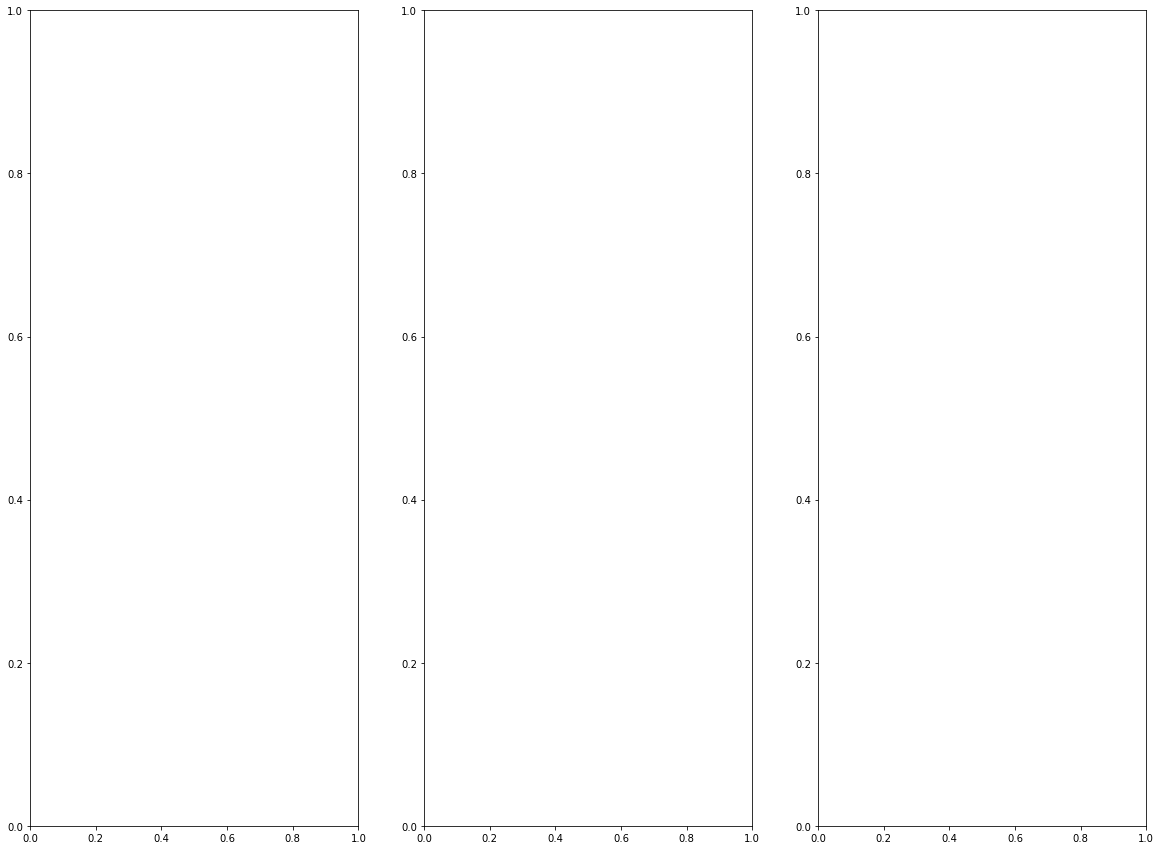

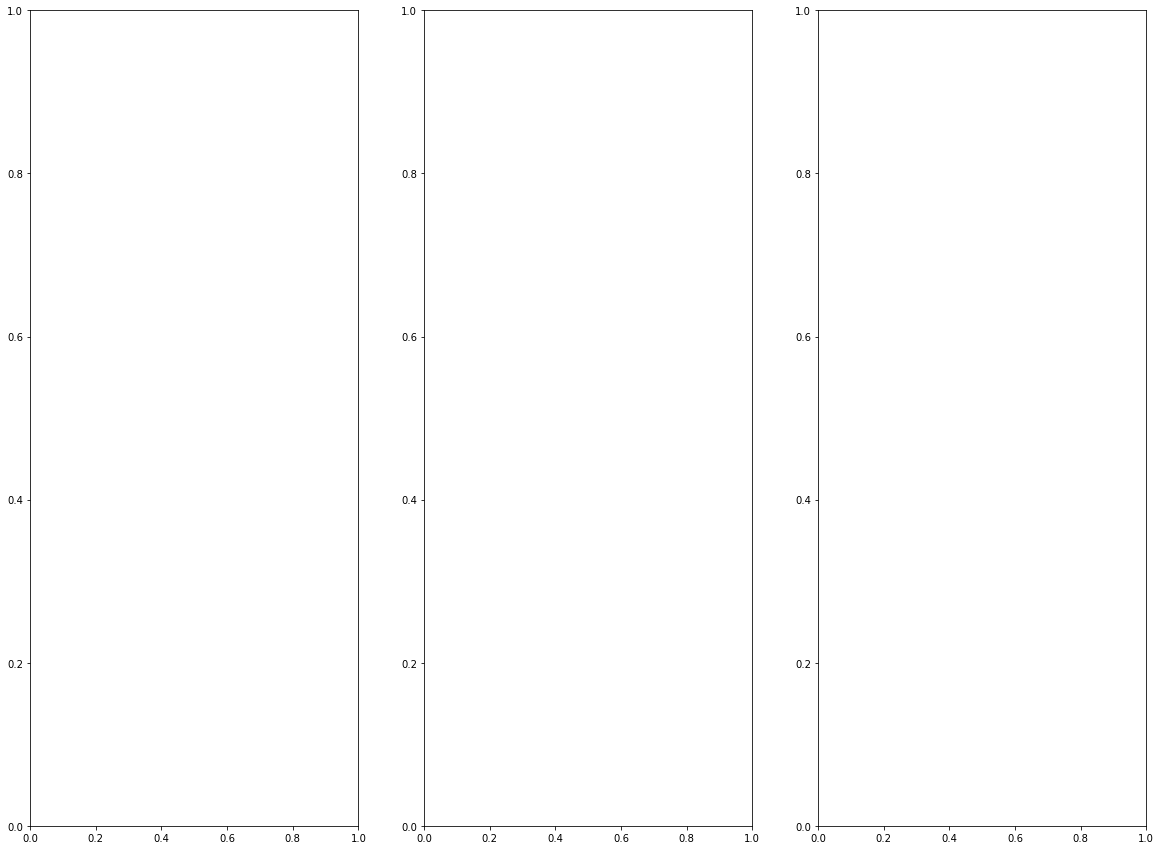

In [50]:
innov_sp = innov_data.query("underlying == 'SPX' or underlying == 'XSP'")
innov_expirations = innov_sp['expiration'].unique()
num_plots = innov_expirations.shape[0]
cols = 3
remainder = 1 if num_plots % cols > 0 else 0 
rows = int(num_plots / cols) + remainder

fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(20,15), sharex=False)
exp_index = 0
for row in range(rows):
    for col in range(cols):
        expiration = innov_expirations[exp_index]
        exp_filter = innov_sp[innov_sp['expiration'] == expiration]
        calls = exp_filter.loc[exp_filter['cp'] == 'c']
        puts = exp_filter.loc[exp_filter['cp'] == 'p']
        axs[row, col].bar(calls['strike'], calls['shares'], color='green', width=2)
        axs[row, col].bar(puts['strike'], puts['shares'], width=2)
        axs[row, col].axvline(spy_price, ls='--', lw=1, color='orange')
        axs[row, col].axhline(0, lw=0.5, color='gray')
        axs[row, col].set_title("Innovator " + pd.to_datetime(expiration).strftime('%m.%d.%y'))
        axs[row, col].set_xlim((200,550))
        axs[row, col].grid(lw=0.5, alpha=0.5)
        exp_index += 1

In [51]:
innov_data.query("underlying == 'SPX' or underlying == 'XSP'")

,date,account,stockticker,cusip,securityname,shares,price,marketvalue,weightings,netassets,sharesoutstanding,creationunits,moneymarketflag,underlying,expiration,strike,cp
0,2023-06-01,APRD,4SPX 240328P03656950,4SPX 240328P03656950,SPX 03/28/2024 3656.95 P,195.0,101.2864,1975084.80,0.2443,8085545.0,325000.0,13.0,,SPX,2024-03-28,3657.0,p
1,2023-06-01,APRD,4SPX 240328P03698040,4SPX 240328P03698040,SPX 03/28/2024 3698.04 P,-208.0,107.3918,-2233749.44,-0.2763,8085545.0,325000.0,13.0,,SPX,2024-03-28,3698.0,p
2,2023-06-01,APRD,4XSP 240328P00369800,4XSP 240328P00369800,XSP 03/28/2024 369.8 P,-65.0,10.7809,-70075.85,-0.0087,8085545.0,325000.0,13.0,,XSP,2024-03-28,370.0,p
8,2023-06-01,APRH,4SPX 240328P03246050,4SPX 240328P03246050,SPX 03/28/2024 3246.05 P,1410.0,56.4800,7963680.00,0.2734,29123550.0,1175000.0,47.0,,SPX,2024-03-28,3246.0,p
9,2023-06-01,APRH,4SPX 240328P03287140,4SPX 240328P03287140,SPX 03/28/2024 3287.14 P,-1457.0,59.9300,-8731801.00,-0.2998,29123550.0,1175000.0,47.0,,SPX,2024-03-28,3287.0,p
10,2023-06-01,APRH,4XSP 240328P00328710,4XSP 240328P00328710,XSP 03/28/2024 328.71 P,-235.0,5.9100,-138885.00,-0.0048,29123550.0,1175000.0,47.0,,XSP,2024-03-28,329.0,p
16,2023-06-01,APRJ,4SPX 240328P02835160,4SPX 240328P02835160,SPX 03/28/2024 2835.16 P,3105.0,32.0700,9957735.00,0.2333,42687540.0,1725000.0,69.0,,SPX,2024-03-28,2835.0,p
17,2023-06-01,APRJ,4SPX 240328P02876250,4SPX 240328P02876250,SPX 03/28/2024 2876.25 P,-3174.0,33.6300,-10674162.00,-0.2501,42687540.0,1725000.0,69.0,,SPX,2024-03-28,2876.0,p
18,2023-06-01,APRJ,4XSP 240328P00287630,4XSP 240328P00287630,XSP 03/28/2024 287.63 P,-345.0,3.3600,-115920.00,-0.0027,42687540.0,1725000.0,69.0,,XSP,2024-03-28,288.0,p
24,2023-06-01,APRQ,4SPX 240328P02424270,4SPX 240328P02424270,SPX 03/28/2024 2424.27 P,3180.0,17.0600,5425080.00,0.1658,32714647.5,1325000.0,53.0,,SPX,2024-03-28,2424.0,p


,date,account,stockticker,cusip,securityname,shares,price,marketvalue,weightings,netassets,sharesoutstanding,creationunits,moneymarketflag,underlying,expiration,strike,cp
0,2023-06-01,APRD,4SPX 240328P03656950,4SPX 240328P03656950,SPX 03/28/2024 3656.95 P,195.0,101.2864,1975084.80,0.2443,8085545.0,325000.0,13.0,,SPX,2024-03-28,3657.0,p
1,2023-06-01,APRD,4SPX 240328P03698040,4SPX 240328P03698040,SPX 03/28/2024 3698.04 P,-208.0,107.3918,-2233749.44,-0.2763,8085545.0,325000.0,13.0,,SPX,2024-03-28,3698.0,p
2,2023-06-01,APRD,4XSP 240328P00369800,4XSP 240328P00369800,XSP 03/28/2024 369.8 P,-65.0,10.7809,-70075.85,-0.0087,8085545.0,325000.0,13.0,,XSP,2024-03-28,370.0,p
8,2023-06-01,APRH,4SPX 240328P03246050,4SPX 240328P03246050,SPX 03/28/2024 3246.05 P,1410.0,56.4800,7963680.00,0.2734,29123550.0,1175000.0,47.0,,SPX,2024-03-28,3246.0,p
9,2023-06-01,APRH,4SPX 240328P03287140,4SPX 240328P03287140,SPX 03/28/2024 3287.14 P,-1457.0,59.9300,-8731801.00,-0.2998,29123550.0,1175000.0,47.0,,SPX,2024-03-28,3287.0,p
10,2023-06-01,APRH,4XSP 240328P00328710,4XSP 240328P00328710,XSP 03/28/2024 328.71 P,-235.0,5.9100,-138885.00,-0.0048,29123550.0,1175000.0,47.0,,XSP,2024-03-28,329.0,p
16,2023-06-01,APRJ,4SPX 240328P02835160,4SPX 240328P02835160,SPX 03/28/2024 2835.16 P,3105.0,32.0700,9957735.00,0.2333,42687540.0,1725000.0,69.0,,SPX,2024-03-28,2835.0,p
17,2023-06-01,APRJ,4SPX 240328P02876250,4SPX 240328P02876250,SPX 03/28/2024 2876.25 P,-3174.0,33.6300,-10674162.00,-0.2501,42687540.0,1725000.0,69.0,,SPX,2024-03-28,2876.0,p
18,2023-06-01,APRJ,4XSP 240328P00287630,4XSP 240328P00287630,XSP 03/28/2024 287.63 P,-345.0,3.3600,-115920.00,-0.0027,42687540.0,1725000.0,69.0,,XSP,2024-03-28,288.0,p
24,2023-06-01,APRQ,4SPX 240328P02424270,4SPX 240328P02424270,SPX 03/28/2024 2424.27 P,3180.0,17.0600,5425080.00,0.1658,32714647.5,1325000.0,53.0,,SPX,2024-03-28,2424.0,p
